# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

## `Задание 02. Сегментация изображений`

#### Фамилия, имя:

Дата выдачи: <span style="color:red">__3 марта 19:00__</span>.

Мягкий дедлайн: <span style="color:red">__17 марта 5:00__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4.25 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2025`

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `U-Net` и `LinkNet`.

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## `Загрузка данных (1 балл)`

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с ImageNet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [1]:
import os
import random

import numpy as np
import numpy.testing as npt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg13, VGG13_Weights
from torchvision import transforms
import torch.nn.functional as F

import matplotlib_inline
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageEnhance

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [2]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images

        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.

        transforms : some collection
            Sequence of transformations for images and masks.
        """
        self.images_dir = images_dir
        self.target_dir = target_dir
        self.transforms = transforms if transforms else (None, None, None)
        self.names = sorted(os.listdir(images_dir))

    def __len__(self):
        # your code here
        return len(self.names)

    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask

        Returns
        -------
        (image, mask)
        """
        img_path = os.path.join(self.images_dir, self.names[idx])
        mask_path = os.path.join(self.target_dir, self.names[idx].rsplit('.', 1)[0] + '.png')

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        transform_img, transform_mask, transform_both = self.transforms
        if transform_both:
            image, mask = transform_both(image, mask)
        if transform_img:
            image = transform_img(image)
        if transform_mask:
            mask = transform_mask(mask)

        return image, mask

## `Модуль аугментации (2 балла)`

Конструктор стандартного `ImageFolder`, принимает параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

1. случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения
2. случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
3. случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
4. случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

Используйте разумные пределы для аугментаций. Одной из причин плохого обучения модели могут быть слишком сильные аугментации. Визуально убедитесь, что граничные случаи достаточно адекватны задаче.

Обратите внимание, что под вырезанием фрагмента подрузумевается вырезания части изображения из исходного, то есть вырезание какой-то части изображения (создание отверстий в изображении). Если после слоя вырезания размеры изображения поменялись, то вы неправильно реализовали модуль.

In [3]:
# your code here
def random_apply(p):
    def decorator(transform_fn):
        def wrapper(self, *args):
            if random.random() < p:
                return transform_fn(self, *args)
            return args if len(args) > 1 else args[0]
        return wrapper
    return decorator

class Transform:
    def __init__(self, p=0.5):
        self.p = p

class Flip(Transform):
    @random_apply(0.5)
    def __call__(self, img, mask):
        return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)

class Cutout(Transform):
    def __init__(self, p=0.5, size=None, min_size=10, max_size=50, fill=0):
        super().__init__(p)
        self.size, self.min_size, self.max_size, self.fill = size, min_size, max_size, fill

    @random_apply(0.5)
    def __call__(self, img, mask):
        width, height = img.size
        cut_w, cut_h = self.size if self.size else (random.randint(self.min_size, self.max_size),
                                                    random.randint(self.min_size, self.max_size))
        x, y = random.randint(0, width - cut_w), random.randint(0, height - cut_h)

        img, mask = img.copy(), mask.copy()
        for draw in (ImageDraw.Draw(img), ImageDraw.Draw(mask)):
            draw.rectangle((x, y, x + cut_w, y + cut_h), fill=self.fill)
        return img, mask

class Brightness(Transform):
    def __init__(self, p=0.5, delta=0.2):
        super().__init__(p)
        self.delta = delta

    @random_apply(0.5)
    def __call__(self, img):
        factor = 1 + random.uniform(-self.delta, self.delta)
        return ImageEnhance.Brightness(img).enhance(factor)

class Background(Transform):
    def __init__(self, p=0.5, backgrounds=None):
        super().__init__(p)
        self.backgrounds = [Image.open(path) for path in backgrounds] if backgrounds else []

    @random_apply(0.5)
    def __call__(self, img, mask):
        if not self.backgrounds:
            return img, mask

        bg = random.choice(self.backgrounds).resize(img.size)
        mask = mask.convert('L').point(lambda x: 255 if x > 0.5 else 0)
        return Image.composite(img, bg, mask.convert('1')), mask

class Composition:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask):
        for t in self.transforms:
            img, mask = t(img, mask)
        return img, mask

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```python
transforms.ToTensor()
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
```

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
DATA_PATH = "/content/drive/MyDrive/people_data/"

image_transforms = transforms.Compose([
    Brightness(p=0.5, delta=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

mask_transforms = transforms.Compose([
    transforms.ToTensor()
])

all_items = os.listdir(os.path.join(DATA_PATH, "train"))
background_samples = random.sample(all_items, 10)
background_paths = [os.path.join(DATA_PATH, "train", item) for item in background_samples]

augmentation_pipeline = Composition([
    Flip(p=0.5),
    Cutout(p=0.5),
    Background(p=0.5, backgrounds=background_paths)
])

train_transforms = (image_transforms, mask_transforms, augmentation_pipeline)
test_transforms = (image_transforms, mask_transforms, None)

train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, "train"),
    target_dir=os.path.join(DATA_PATH, "train_mask"),
    transforms=train_transforms
)

test_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, "test"),
    target_dir=os.path.join(DATA_PATH, "test_mask"),
    transforms=test_transforms
)

Функция для отображения изображения:

In [6]:
def show_idx_image(dataset, idx):
    image, mask = dataset[idx]

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.squeeze(0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(image)
    axes[1].imshow(mask)

    axes[0].set_axis_off()
    axes[1].set_axis_off()

    fig.tight_layout()
    plt.show()

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных. Необходимо проверить каждый модуль аугментации отдельно, в ином случае будут сниматься баллы.

**Важно:** Проверьте корректность работы модулей, действительно ли маска изображения корректна для изображения после аугментации.


Исходное изображение


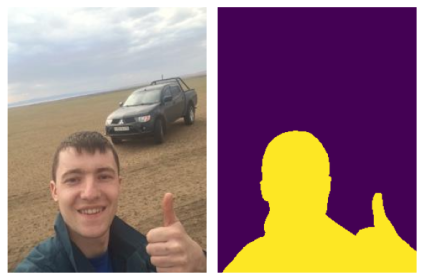


Горизонтальное отражение


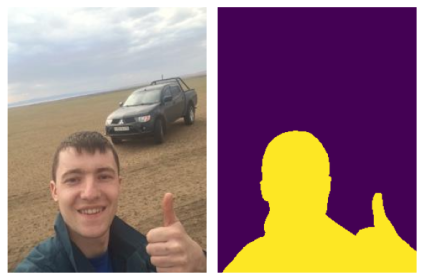


Вырезание фрагмента


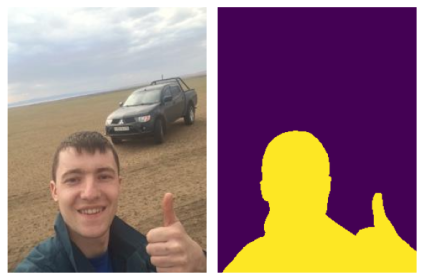


Изменение яркости


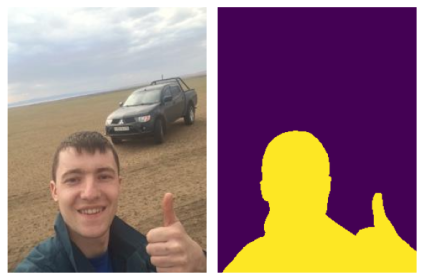


Изменение фона


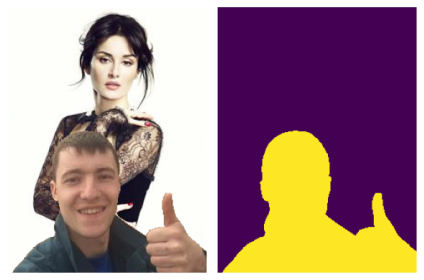

In [7]:
# your code here
num = 10

default_image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

default_mask_transform = transforms.Compose([transforms.ToTensor()])

def test_augmentation(name, image_transform=None, mask_transform=None, augment=None):
    print(f"\n{name}")

    transforms_train = (
        image_transform or default_image_transform,
        mask_transform or default_mask_transform,
        augment
    )

    dataset = PhotosDataset(
        images_dir=os.path.join(DATA_PATH, "train"),
        target_dir=os.path.join(DATA_PATH, "train_mask"),
        transforms=transforms_train
    )
    show_idx_image(dataset, num)

augmentations = {
    "Исходное изображение": {},
    "Горизонтальное отражение": {"augment": Flip(p=1)},
    "Вырезание фрагмента": {"augment": Cutout(p=1, size=(100, 100))},
    "Изменение яркости": {"image_transform": transforms.Compose([Brightness(p=1, delta=1), default_image_transform])},
    "Изменение фона": {"augment": Background(p=1, backgrounds=[
        os.path.join(DATA_PATH, "train", img) for img in random.sample(os.listdir(os.path.join(DATA_PATH, "train")), 10)
    ])}
}

for name, params in augmentations.items():
    test_augmentation(name, **params)



## `Загрузчики`

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и так далее) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

Обычно, скорость обработки данных на GPU превышает скорость загрузки данных в одном процессе, поэтому типичное значение для `num_workers`$\approx 3\text{-}10$.

Учтите, что на некоторых системах в Jupyter Notebook при `num_workers`$>0$ `DataLoader` перестаёт работать. В таком случае установите это значение в $0$.

In [8]:
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=2)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=2, shuffle=True)

## `DiceLoss (1 балл)`

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через `torch.nn.Module`. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат **Dice Loss** определим как:

$$
\text{Dice Coefficient} = 2\frac{|A \cap B| }{|A| + |B|} \leadsto \text{Dice Loss} = 1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — истинная разметка для пикселя изображения.

In [9]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:

            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed.
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits

    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        true_labels = true_labels.to(torch.long)

        if self.with_logits:
            # your code here
            logits = torch.sigmoid(logits)

        # your code here
        intersection = torch.sum(logits * true_labels, dim=[1, 2])
        union = torch.sum(logits + true_labels, dim=[1, 2]) + self.eps
        loss = 1 - 2 * intersection / union

        if self.reduction == 'sum':
            # your code here
            loss_value = torch.sum(loss)
        elif self.reduction == 'mean':
            # your code here
            loss_value = torch.mean(loss)
        elif self.reduction is None:
            # your code here
            loss_value = loss

        return loss_value

Проверка реализации:

In [10]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## `U-Net (3 балла)`

Для решения задачи сегментации будем использовать [U-Net](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`.

Концептуальная схема представлена на диаграмме ниже:

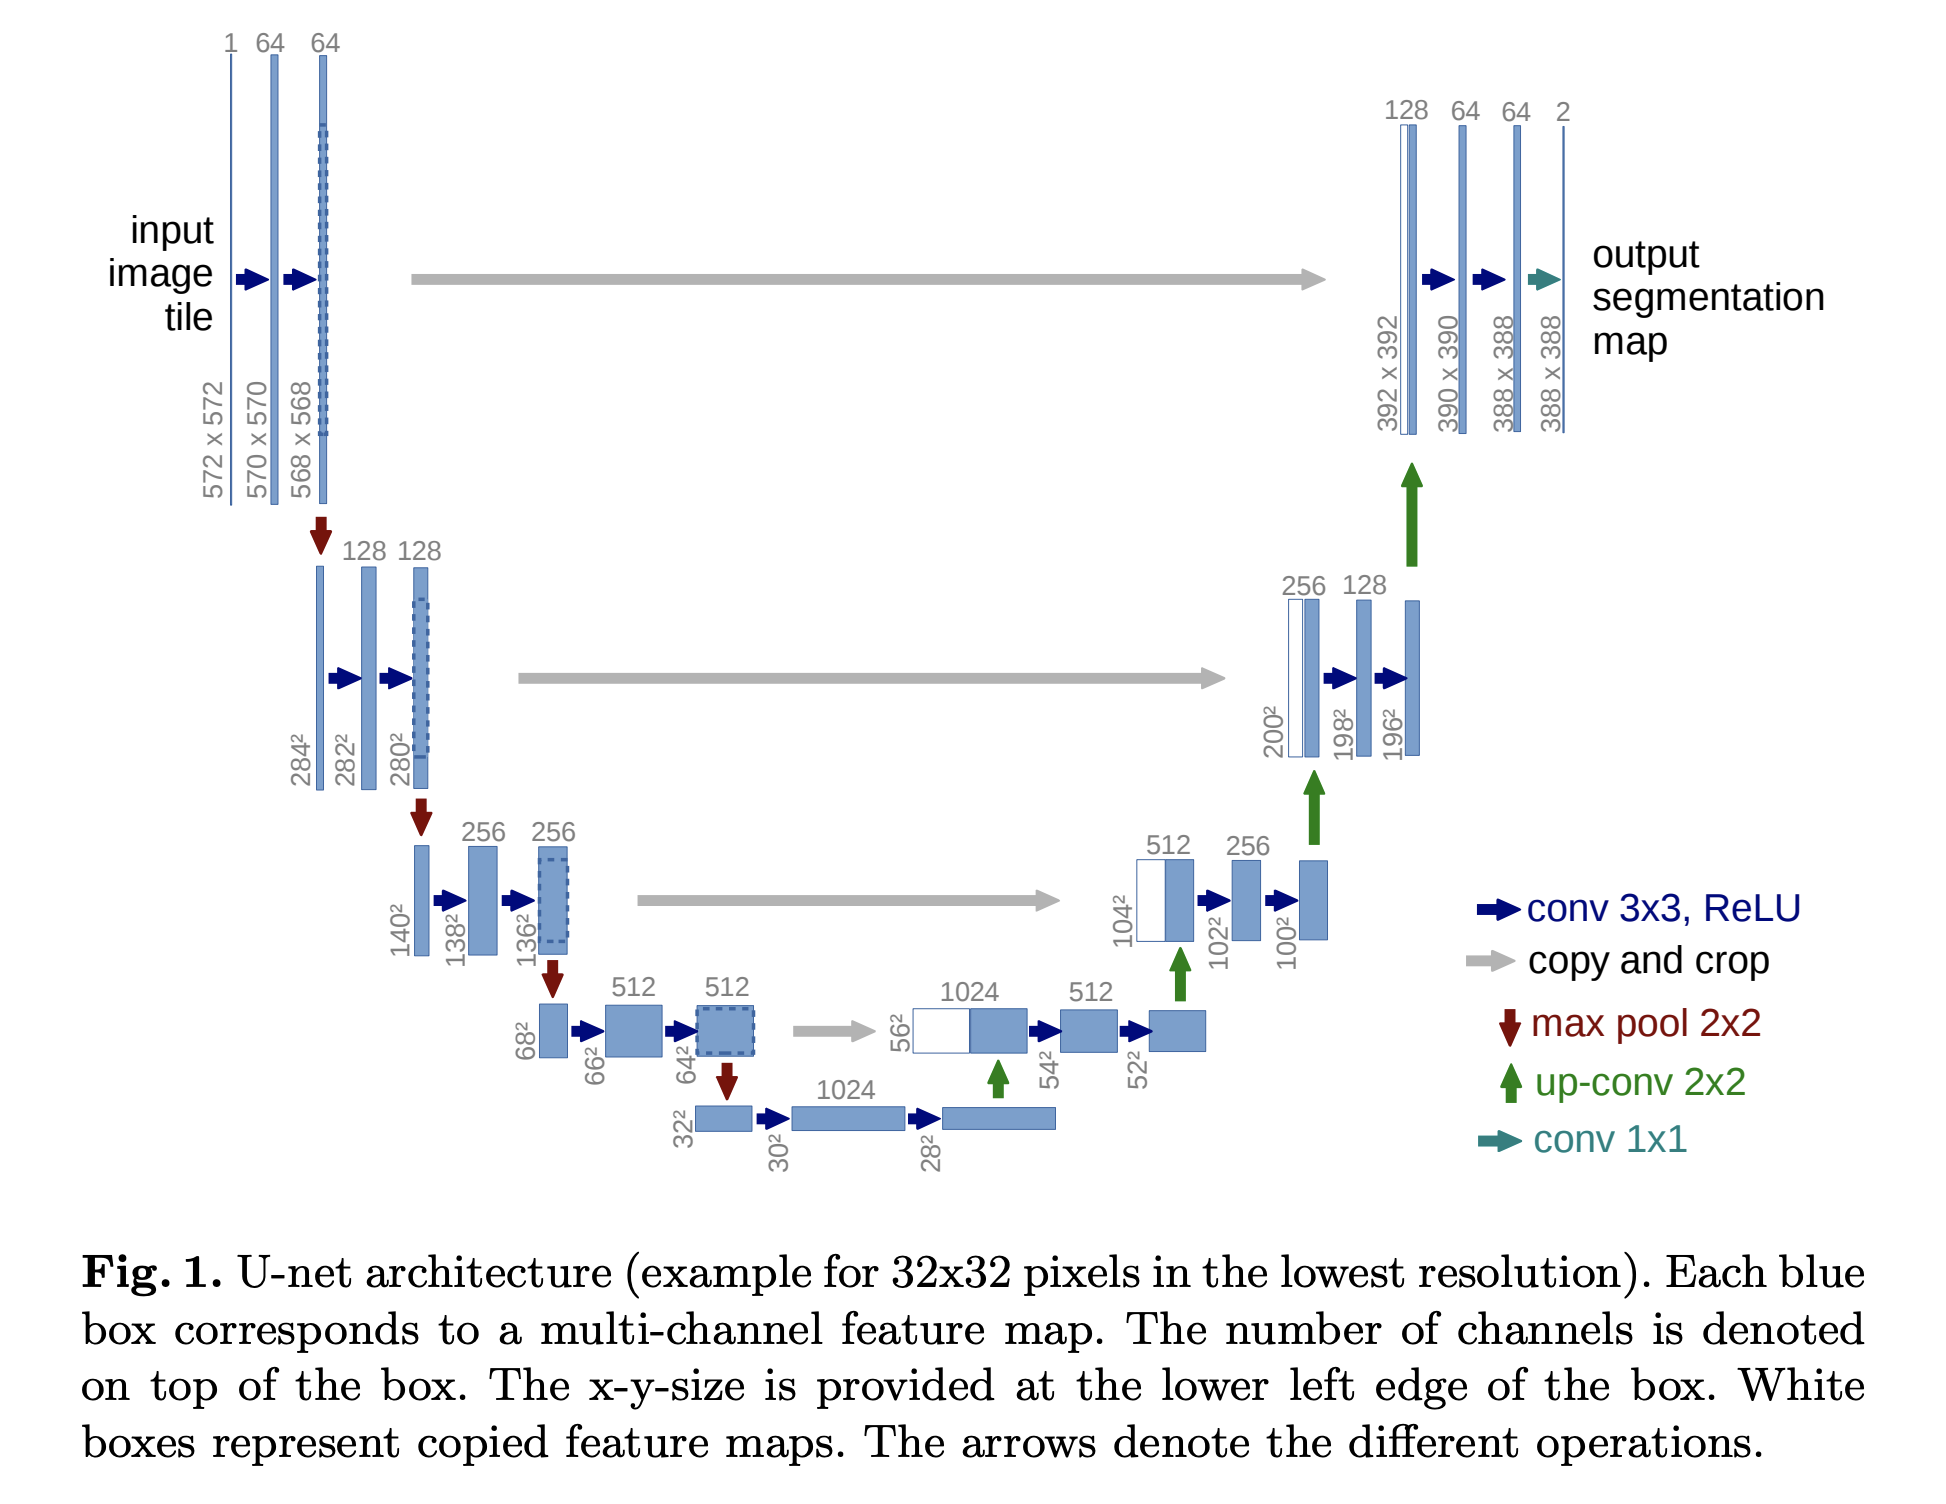

Заметим, что блоки VGG13 имеют следующий вид:
```python
    (0): Conv2d(...)
    (1): ReLU(...)
    (2): Conv2d(...)
    (3): ReLU(...)
    (4): MaxPool2d(...)
```

Для удобства, уберём слои `MaxPool2d` из блоков энкодера и будем применять pooling отдельно. Возможно, вам будет полезно вывести архитектуру модели `VGG` и изучить параметры слоев pooling.

При реализации `Decoder` вам пригодится интерполяция, для этого можно использовать `torch.nn.functional.interpolate` с `mode=nearest`.

Реализуйте архитектуру данной сети.

#### `Encoder`

In [11]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, weights=VGG13_Weights.DEFAULT):
        super().__init__()
        self.num_blocks = num_blocks

        # Будем использовать предобученную VGG13 в качестве backbone
        feature_extractor = vgg13(weights=weights).features

        # Каждый блок энкодера U-Net — это блок VGG13 без MaxPool2d
        self.blocks = torch.nn.ModuleList()

        start = 0
        for idx in range(self.num_blocks):
            # Находим конец текущего блока (в VGG13 слои идут 2 Conv + ReLU + MaxPool)
            end = start + 4  # Conv -> ReLU -> Conv -> ReLU (без MaxPool)
            self.blocks.append(torch.nn.Sequential(*feature_extractor[start:end]))
            start = end + 1  # Пропускаем MaxPool

    def forward(self, x):
        activations = []
        for block in self.blocks:
            # your code here
            x = block(x)

            # Сохраните активации для передачи их в декодер
            # your code here
            activations.append(x)

            # При необходимости примените max-pool
            # Можно использовать torch.functional.F.max_pool2d
            # your code here
            x = F.max_pool2d(x, kernel_size=2, stride=2)

        return activations

In [12]:
assert sum((param.numel() for param in VGG13Encoder(num_blocks=1).parameters())) == 38720
assert sum((param.numel() for param in VGG13Encoder(num_blocks=2).parameters())) == 260160
assert sum((param.numel() for param in VGG13Encoder(num_blocks=3).parameters())) == 1145408

x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)
out = VGG13Encoder(num_blocks=3)(x)

assert len(out) == 3
npt.assert_almost_equal(torch.linalg.norm(out[0]).item(), 902.218, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[1]).item(), 571.030, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[2]).item(), 648.068, decimal=3)

#### `Decoder`

In [13]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()

    def forward(self, down, left):
        # Upsample x2 и свёртка
        # your code here
        x = torch.nn.functional.interpolate(down, scale_factor=2, mode="nearest")
        x = self.upconv(x)
        x = self.relu(x)

        # Конкатенация выхода энкодера и предыдущего блока декодера
        # your code here
        x = torch.cat([x, left], dim=1)

        # Две свёртки с ReLu
        # your code here
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        return x

In [14]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

#### `U-Net`

In [15]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        # your code here
        self.encoder = VGG13Encoder(num_blocks=num_blocks)

        # your code here
        self.decoder = Decoder(64, num_blocks-1)

        # Свёртка 1x1 для попиксельной агрегации каналов
        # your code here
        self.conv = torch.nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        # your code here
        res = self.encoder(x)
        x = self.decoder(res)
        x = self.conv(x)

        return x

In [16]:
model = UNet(num_classes=1, num_blocks=3)
x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)

assert sum((param.numel() for param in model.parameters())) == 2067649
assert list(model(x).shape) == [1, 1, 320, 240]
model

UNet(
  (encoder): VGG13Encoder(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0): DecoderBlock(
        (upconv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       

### `Оценивание качества сети`


Обычно, оптимизируемый функционал сложно интерпретировать, а так же в разных экспериментах могут использоваться разные функции потерь. Поэтому необходимо замерять и отслеживать независимую метрику качества. Предлагается использовать **IoU (Intersection over Union)** — один из стандартных вариантов для задачи сегментации:
$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|} = \frac{\sum\limits_{ij}a_{ij}b_{ij}}{\sum\limits_{ij}a_{ij} + b_{ij} - a_{ij}b_{ij}}
$$

Учтите, что знаменатель может быть равен нулю, например, если маска нулевая. Такие объекты можно не учитывать при агрегации и пропускать, так как в ином случае подсчет метрики на всем батче будет NaN. В pytorch есть встроенные для этого функции с префиксом nan.


In [17]:
class IoUScore(torch.nn.Module):
    def __init__(self, threshold, reduction=None):
        """
        Arguments
        ---------
        threshold : float
            threshold for logits binarization
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:

            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed.
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()

        self.threshold = threshold
        self.reduction = reduction

    @torch.no_grad()
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        # your code here
        preds = logits > self.threshold
        intersection = (preds & true_labels.bool()).sum(dim=(1, 2))
        union = preds.sum(dim=(1, 2)) + true_labels.sum(dim=(1, 2)) - intersection

        score = torch.where(union > 0, intersection / union, torch.tensor(1.0, device=logits.device))

        if self.reduction == 'sum':
            # your code here
            return score.sum()
        if self.reduction == 'mean':
            # your code here
            return score.mean()

        return score


In [18]:
logits = torch.tensor([
    [
        [0.3089,  0.4311, -0.9711],
        [0.9030,  1.0325, -0.7607],
        [0.9648, -0.5528, -1.1010]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ]
])
true_labels = torch.tensor([
    [
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], [
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 0.]
    ], [
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]
    ]
])

scores = IoUScore(0.0)(logits, true_labels)
npt.assert_almost_equal(scores.numpy(), np.array([0.3333, 1.0000, 0.5556]), decimal=4)

score = IoUScore(0.0, reduction='sum')(logits, true_labels)
npt.assert_almost_equal(score.item(), 1.8889, decimal=4)

score = IoUScore(0.0, reduction='mean')(logits, true_labels)
npt.assert_almost_equal(score.item(), 0.6296, decimal=4)

### `Логирование`

При реализации цикла обучения необходимо сохранять метрики $1\text{-}9$ с использованием модуля [torch.utils.tensorboard](https://pytorch.org/docs/stable/tensorboard.html) или с помощью модуля [wandb](https://docs.wandb.ai/tutorials/) вам предлагается самим выбрать более удобный для вас модуль.

Для отслеживания процесса обучения обычно требуется сохранять информацию разных его аспектах.

Для полного контроля над процессом обучения обычно требуется сохранять информацию о разных статистиках. Самыми очевидными являются:
1. Значение функции потерь (лосса) на обучающей и тестовой выборках
2. Метики качества, например, **Dice Coefficient** и **IoU (Intersection over Union)** на обучающей и тестовой выборках

Однако, суррогатные метрики могут не отражать реального качества. Поэтому для моделей, которые выдают визуализируемый результат, обычно логируют предсказания для некоторых объектов выборки. В задаче сегментации естественным вариантом является логирование четвёрки: исходное изображение, истинная маска, маска вероятностей истинного класса, бинаризованная маска.

*Замечание:* лосс и качество на обучающей выборке обычно логируют не только в конце каждой эпохи, но и по отдельным батчам на каждой итерации.

3. Чтобы отслеживать динамику обучения необходимо зафиксировать небольшой набор объектов обучающей и тестовой выборок и после каждой эпохи обучения логировать указанные четыре картинки для каждого объекта.

*Замечание:* можно логировать четвёрки изображений независимо, однако, удобнее объединить их на одной фигуре [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_figure), [реализация через Wandb](https://docs.wandb.ai/guides/track/log/plots/#matplotlib-and-plotly-plots) (лучше делать через fig и Image). Дополнительный плюс — возможность подписать значения метрик для этого объекта в заголовке изображения или добавить colorbar для более простой интерпретации предсказанной маски.

Для удобной категоризации экспериментов обычно в начале обучения сохраняют:

4. Гиперпараметры модели [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_hparams), [реализация через Wandb](https://docs.wandb.ai/guides/track/config/)
5. Структуру модели [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph), **про реализацию wandb ниже**

Для исследования технических особенностей обучения полезно логировать следующие статистики:

6. Распределение весов, активаций, градиентов [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_histogram), [реализация через Wandb](https://docs.wandb.ai/ref/python/data-types/histogram/). Сохранять гистограммы каждого параметра после каждой итерации может быть вычислительно неэффективно, поэтому обычно сохраняют распределения весов для каждого отдельного слоя нейронной сети после каждой эпохи.
7. Норма весов и норма градиента на каждой итерации

Наконец, после каждой эпохи можно визуализировать промежуточные представления входных данных:

8. Активации после каждого слоя/блока, как изображения
9. Градиенты функции потерь по активациям для некоторых объектов обучающей выборки, как изображения

*Замечание:* для реализации пунктов 8, 9 менять код модели не требуется. Используйте хуки: [register_full_backward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook) (данный хук не работает с inplace операциями, например, с `torch.nn.ReLU(inplace=True)`. Или не используйте inplace операции, или используйте [`Tensor.register_hook`](https://github.com/pytorch/pytorch/issues/61519)), [register_forward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook).

Файлы с логами, а также чекпоинты весов модели после итерации с наилучшим валидационным качеством (смотрите [torch.save](https://pytorch.org/docs/stable/generated/torch.save.html) и [torch.nn.Module.state_dict](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)) для **ВСЕХ** проведённых экспериментов (за исключением упавших, недосчитанных и так далее) необходимо сдать в anytask.

#### `Некоторые советы по wandb`

- При логировании всегда указывайте параметр step, который должен не уменьшаться.

- При логировании изображений лучше их нормировать в диапазон [0, 1] как в функции `show_idx_image` выше. Для логирования предсказаний маски, лучше использовать вероятности. При неправильном диапозоне изображения могут отображаться неверно!

- Вместо логирования изображений, лучше логировать `matplotlib` графики и соответсвующие им `figure`. Кроме того, лучше закрывать все открытые графики, чтобы не перегружать ноутбук. Пример кода:


```python
fig, ax = plt.subplots(...)
...
wandb.log({key: wandb.Image(fig)}, step=global_step)
plt.close('all')
```

- Функционал построение bins в `wandb.Histogram` ограничен, можете посмотреть в сторону аргумента `np_histogram`.

- Wandb не имеет широкого функционала для логирования структуры модели. Есть способ через wandb.watch(net, log_graph=True), но получаемый результаты сильно отличаются от возможностей `tensorboard`. К счастью, `wandb` умеет синхронизировать логи с `Tensorboard` поэтому можно использовать следующую логику:


```python
wandb.init(
    project=project_name,
    name=run_name,
    config=config,
    sync_tensorboard=True        # Синхронизация с tensorboard
)

writer = SummaryWriter(run_name) # Создание логера tensorboard

# Логирование графа модели
writer.add_graph(net, input_x)
writer.close()

train_loop(...)
wandb.finish()
```

- `wandb` по умолчанию сохраняет все логи локально и на сайте в вашем личном хранилище. В случае перезагрузки `Google Colab` локальные файлы не сохраняются! Кроме того, скачивание файлов не через GoogleDisk достаточно продолжительное (в районе 20-30 минут).

- В `wandb` можно легко сохранять код и указать директорию, так вы никогда не забудете какой именно код получает результаты логов.

```python
wandb.init(..., settings=wandb.Settings(code_dir="."))
```

Кроме того, можно сохранить отдельные файлы:

```python
wandb.init(..., save_code=True)
wandb.run.log_code(
    "./",
    include_fn=lambda path: condition(path)
)
```

- В `wandb` есть функция для автоматического логирования весов и градиентов модели `wandb.watch()`, но функционал слишком ограничен и накладывает слишком много накладных расходов. **Лучше писать руками!**

#### `Некоторые советы по tensorboard`

- Функционал и возможности `tensorboard` шире (работа с 3D, продвинутые визуализации).

- `tensorboard` сохраняет логи только локально, то есть после закрытия `Google Colab` ничего не сохранится. В реальных проектах это является сильной стороной, так как гарантирует безопасность и конфиденциальность.

- Для визуализации логов достаточно запустить в ноутбуке или в терминале соответсвующее расширение, однако в случае `Google Colab` для этого приходится прокидывать порты, [подробнее тут](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).

- `tensorboard` меньше лагает и более легковесный.


### `Некоторые советы по логированию`

- Вы можете выбрать либо `wandb`, либо `tensorboard`.

- В реальных проектах лучше добавить логирование кода с целью сохранения и воспроизводимости результатов.

- Называйте запуски осмысленно, чтобы по названию можно было понять смысл запуска и варьеруемые параметры.


### `Эксперименты`

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке.

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации:
1. Только кросс-энтропия
2. Только dice loss
3. Сумма двух лоссов с весами (попробуйте $3\text{-} 4$ разных соотношения)

**Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.**

In [19]:
import wandb
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.nn as nn

In [20]:
def train(
    model_name,
    model,
    train_loader,
    test_loader,
    num_epochs=10,
    device="cuda" if torch.cuda.is_available() else "cpu",
    loss_strategy="bce",
    bce_weight=0.5,
    dice_weight=0.5,
    lr=1e-4,
    save_dir="checkpoints",
    project_name="unet-segmentation"
):
    save_dir = f"/content/drive/MyDrive/{save_dir}"
    os.makedirs(save_dir, exist_ok=True)

    model = model.to(device)

    config = {
        "model_type": model_name,
        "loss_strategy": loss_strategy,
        "bce_weight": bce_weight if "combined" in loss_strategy else 0,
        "dice_weight": dice_weight if "combined" in loss_strategy else 0,
        "learning_rate": lr,
        "num_epochs": num_epochs,
        "batch_size": 8
    }

    wandb.init(project=project_name, name=loss_strategy, config=config)

    bce_criterion = nn.BCEWithLogitsLoss()
    dice_criterion = DiceLoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=lr)
    iou_metric = IoUScore(threshold=0.5, reduction='mean')

    vis_samples = []
    for i in range(3):
        sample = test_loader.dataset[i]
        image, mask = sample[0], sample[1]
        vis_samples.append((image.unsqueeze(0), mask.unsqueeze(0)))

    activations = {}
    gradients = {}

    def get_activation(name):
        def hook(module, input, output):
            activations[name] = output.detach()
        return hook

    def get_gradient(name):
        def hook(module, grad_input, grad_output):
            gradients[name] = grad_output[0].detach()
        return hook

    model.encoder.blocks[0].register_forward_hook(get_activation('encoder_block_0'))
    model.encoder.blocks[0].register_full_backward_hook(get_gradient('encoder_block_0'))

    best_iou = 0
    global_step = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_iou = 0

        for batch_idx, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            logits = model(images)

            if loss_strategy == "bce":
                loss = bce_criterion(logits, masks)
            elif loss_strategy == "dice":
                loss = dice_criterion(logits, masks)
            elif loss_strategy == "combined":
                bce_loss = bce_criterion(logits, masks)
                dice_loss = dice_criterion(logits, masks)
                loss = bce_weight * bce_loss + dice_weight * dice_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                batch_iou = iou_metric(logits, masks).item()

            train_loss += loss.item()
            train_iou += batch_iou

            if batch_idx % 20 == 0:
                wandb.log({
                    "train/batch_loss": loss.item(),
                    "train/batch_iou": batch_iou
                }, step=global_step)

            global_step += 1

        avg_train_loss = train_loss / len(train_loader)
        avg_train_iou = train_iou / len(train_loader)

        model.eval()
        test_loss = 0
        test_iou = 0

        with torch.no_grad():
            for images, masks in test_loader:
                images = images.to(device)
                masks = masks.to(device)

                logits = model(images)

                if loss_strategy == "bce":
                    loss = bce_criterion(logits, masks)
                elif loss_strategy == "dice":
                    loss = dice_criterion(logits, masks)
                elif loss_strategy == "combined":
                    bce_loss = bce_criterion(logits, masks)
                    dice_loss = dice_criterion(logits, masks)
                    loss = bce_weight * bce_loss + dice_weight * dice_loss

                batch_iou = iou_metric(logits, masks).item()

                test_loss += loss.item()
                test_iou += batch_iou

        avg_test_loss = test_loss / len(test_loader)
        avg_test_iou = test_iou / len(test_loader)

        wandb.log({
            "train/epoch_loss": avg_train_loss,
            "train/epoch_iou": avg_train_iou,
            "test/epoch_loss": avg_test_loss,
            "test/epoch_iou": avg_test_iou,
            "epoch": epoch
        }, step=global_step)

        print(f"Эпоха {epoch+1}"
              f"Тест: {avg_test_loss:.4f}, IoU: {avg_test_iou:.4f}")

        if epoch % 5 == 0:
            visualize_predictions(model, vis_samples, device, iou_metric, global_step)

        if avg_test_iou > best_iou:
            best_iou = avg_test_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'test_iou': avg_test_iou
            }, os.path.join(save_dir, f"{loss_strategy}_best.pth"))

    wandb.finish()
    return model, best_iou


def visualize_predictions(model, samples, device, iou_metric, global_step):
    model.eval()
    with torch.no_grad():
        for idx, (image, mask) in enumerate(samples):
            image = image.to(device)
            mask = mask.to(device)

            logits = model(image)
            probs = torch.sigmoid(logits)
            pred = probs > 0.5

            sample_iou = iou_metric(logits, mask)

            image_np = image.cpu().squeeze().permute(1, 2, 0).numpy()
            image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-8)

            mask_np = mask.cpu().squeeze().numpy()
            probs_np = probs.cpu().squeeze().numpy()
            pred_np = pred.cpu().squeeze().numpy()

            fig, axes = plt.subplots(1, 4, figsize=(16, 4))

            axes[0].imshow(image_np)
            axes[0].set_title("Входное изображение")
            axes[0].axis('off')

            axes[1].imshow(mask_np, cmap='gray')
            axes[1].set_title("Истинная маска")
            axes[1].axis('off')

            im = axes[2].imshow(probs_np, cmap='jet', vmin=0, vmax=1)
            axes[2].set_title(f"Вероятности (IoU: {sample_iou:.4f})")
            axes[2].axis('off')
            fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

            axes[3].imshow(pred_np, cmap='gray')
            axes[3].set_title("Предсказанная маска")
            axes[3].axis('off')

            plt.tight_layout()
            wandb.log({f"samples/test_{idx}": wandb.Image(fig)}, step=global_step)
            plt.close(fig)


def compare_loss_strategies(
    model_name,
    model_class,
    train_loader,
    test_loader,
    num_epochs=10,
    lr=1e-4,
    device="cuda" if torch.cuda.is_available() else "cpu",
    project_name="unet-segmentation-comparison",
    save_dir="checkpoints"
):
    strategies = [
        {"name": "bce_only", "strategy": "bce", "bce_weight": 1.0, "dice_weight": 0.0},
        {"name": "dice_only", "strategy": "dice", "bce_weight": 0.0, "dice_weight": 1.0},
        {"name": "combined_50_50", "strategy": "combined", "bce_weight": 0.7, "dice_weight": 0.3}
    ]

    results = {}

    for strategy in strategies:
        model = model_class(num_classes=1, num_blocks=3)
        model = model.to(device)

        _, best_iou = train(
            model_name=model_name,
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            num_epochs=num_epochs,
            device=device,
            loss_strategy=strategy['strategy'],
            bce_weight=strategy['bce_weight'],
            dice_weight=strategy['dice_weight'],
            lr=lr,
            save_dir=save_dir,
            project_name=project_name
        )

        results[strategy['name']] = best_iou

    wandb.init(project=project_name, name="comparison")

    fig, ax = plt.subplots(figsize=(10, 6))
    strategies = list(results.keys())
    ious = list(results.values())

    ax.bar(strategies, ious)
    ax.set_ylabel('IoU на тесте')
    ax.set_title('Сравнение стратегий функций потерь')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    wandb.log({"comparison": wandb.Image(fig)})
    plt.close(fig)

    wandb.finish()

    return results

In [21]:
res = compare_loss_strategies(
    model_name='UNet',
    model_class=UNet,
    train_loader=train_data_loader,
    test_loader=test_data_loader,
    num_epochs=10,
    lr=1e-4,
    device="cuda" if torch.cuda.is_available() else "cpu",
    project_name="unet",
    save_dir="checkpoints"
)

for s, iou in res.items():
    print(f"{s} - {iou:.4f}")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: geraklthebest22 (geraklthebest22-msu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Эпоха 1Тест: 0.4444, IoU: 0.6546
Эпоха 2Тест: 0.3767, IoU: 0.6401
Эпоха 3Тест: 0.3379, IoU: 0.7066
Эпоха 4Тест: 0.3346, IoU: 0.7316
Эпоха 5Тест: 0.3342, IoU: 0.7068
Эпоха 6Тест: 0.3213, IoU: 0.7483
Эпоха 7Тест: 0.3047, IoU: 0.7272
Эпоха 8Тест: 0.2877, IoU: 0.7481
Эпоха 9Тест: 0.2952, IoU: 0.7553
Эпоха 10Тест: 0.3741, IoU: 0.6470


epoch,▁▂▃▃▄▅▆▆▇█
test/epoch_iou,▂▁▅▇▅█▆██▁
test/epoch_loss,█▅▃▃▃▃▂▁▁▅
train/batch_iou,▁▄▆▆▅▅▆▆▆▅▆▇▅▇▇▇▇▆▇▆▇▇▆▆▇▇▇█▇█▇▆▇▆▇▇▇▇██
train/batch_loss,█▇▅▄▅▅▃▄▄▅▃▃▃▃▃▂▃▄▄▃▂▃▃▃▂▂▂▂▁▂▃▂▂▂▃▄▂▁▂▂
train/epoch_iou,▁▄▅▆▆▇▇▇██
train/epoch_loss,█▆▄▃▃▂▂▂▁▁
epoch,9
test/epoch_iou,0.64704
test/epoch_loss,0.37407
train/batch_iou,0.88211


Эпоха 1Тест: 0.3026, IoU: 0.6045
Эпоха 2Тест: 0.3026, IoU: 0.6045
Эпоха 3Тест: 0.3026, IoU: 0.6045
Эпоха 4Тест: 0.3026, IoU: 0.6045
Эпоха 5Тест: 0.3026, IoU: 0.6045
Эпоха 6Тест: 0.3026, IoU: 0.6045
Эпоха 7Тест: 0.3026, IoU: 0.6045
Эпоха 8Тест: 0.3026, IoU: 0.6045
Эпоха 9Тест: 0.3026, IoU: 0.6045
Эпоха 10Тест: 0.3026, IoU: 0.6045


epoch,▁▂▃▃▄▅▆▆▇█
test/epoch_iou,▁▁▁▁▁▁▁▁▁▁
test/epoch_loss,▁▁▁▁▁▁▁▁▁▁
train/batch_iou,▃▇▇▃▄▂▅▆▃▅▄▅▅▅▂▄▃█▄█▇▃▅▆▆▇▄▄▁▁▇▆▂▅▃▇▅▅▅▅
train/batch_loss,█▄▂▂▅▃▄▄▂▃▃▃▃▅▃▅▃▃▂▃▃▆▂▃▄▃▇▅▄▁▆▄▃▃▃▃▃▂▂▃
train/epoch_iou,▁█████████
train/epoch_loss,█▁▁▁▁▁▁▁▁▁
epoch,9
test/epoch_iou,0.60452
test/epoch_loss,0.30261
train/batch_iou,0.6097


Эпоха 1Тест: 0.3662, IoU: 0.6806
Эпоха 2Тест: 0.3490, IoU: 0.7266
Эпоха 3Тест: 0.3687, IoU: 0.7334
Эпоха 4Тест: 0.3104, IoU: 0.7236
Эпоха 5Тест: 0.3213, IoU: 0.7475
Эпоха 6Тест: 0.2977, IoU: 0.7540
Эпоха 7Тест: 0.3352, IoU: 0.7501
Эпоха 8Тест: 0.3007, IoU: 0.7562
Эпоха 9Тест: 0.2968, IoU: 0.7640
Эпоха 10Тест: 0.2677, IoU: 0.7622


epoch,▁▂▃▃▄▅▆▆▇█
test/epoch_iou,▁▅▅▅▇▇▇▇██
test/epoch_loss,█▇█▄▅▃▆▃▃▁
train/batch_iou,▁▆▇▆▆▇▇▆▇▇▇▆▇▇▆▇▆▇▇▇▇█▆▇▇▆█▇▇▇█▇██▇▇▆███
train/batch_loss,█▇█▄▄▄▄▄▅▄▃▅▃▄▃▃▃▄▄▄▂▂▂▄▃▁▅▃▂▃▃▁▃▂▂▂▃▂▂▁
train/epoch_iou,▁▄▅▆▆▇▇███
train/epoch_loss,█▅▄▃▃▂▂▁▁▁
epoch,9
test/epoch_iou,0.76217
test/epoch_loss,0.26769
train/batch_iou,0.81394


bce_only - 0.7553
dice_only - 0.6045
combined_50_50 - 0.7640


# ВЫВОДЫ
## Сравнение функций потерь и метрик качества

**Поведение функций потерь:** Комбинированная функция потерь показывает наиболее эффективное обучение, достигая минимальных значений (0.22-0.27) как на обучающей, так и на тестовой выборках. Bce показывает схожую динамику снижения на начальном этапе, но с  колебаниями и резким возрастанием в конце обучения на тестовой выборке, что указывает на возможное переобучение. Функция Dice Loss показывает наихудшие результаты - практически постоянное значение ~0.30 без признаков улучшения в процессе обучения.

**Динамика IoU:** График IoU подтверждает превосходство комбинированной функции, которая достигает значений 0.77 с минимальными колебаниями. Bce достигает таких же значений (0.75) на пике, но с большей нестабильностью. Dice Loss стабильно показывает низкую производительность с IoU около 0.59-0.60 без улучшения.

## Предсказания на тестовых образцах

Визуализация примеров сегментации наглядно показывает разницу в качестве предсказаний. Модель с комбинированной функцией потерь обеспечивает наиболее четкую и точную сегментацию. Bce также дает приемлемые результаты, но с худшей детализацией некоторых границ. Dice Loss демонстрирует самые низкокачественные результаты с грубыми ошибками сегментации - на нескольких образцах видно, что модель с Dice Loss игнорирует значительные части объектов или неправильно классифицирует области фона.

## Поведение на уровне батчей

Графики показывают высокую вариабельность для всех функций потерь, что характерно для сегментации. Однако комбинированная функция и Bce стабильно держат более высокие значения IoU (0.75-0.85), в то время как Dice Loss стабильно показывает более низкие значения (0.55-0.65).

## Выводы

1. **Комбинированная функция потерь (BCE + Dice)** обеспечивает оптимальный баланс между стабильностью обучения и качеством сегментации. Она объединяет преимущества обоих подходов: BCE эффективно обрабатывает локальную информацию на уровне пикселей, а Dice оптимизирует общую область перекрытия.

2. **Bce** может обеспечивать хорошие результаты, но подвержена большей нестабильности и переобучения, особенно на поздних стадиях обучения.

3. **Dice Loss** отсутствует прогресс в обучении


## `LinkNet (2 балла)`

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections (сложения). Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

*Подсказка:* так как конкатенации слоёв заменили на skip-connections, то ожидается, что число параметров стало меньше.

**Обучите сеть и проведите анализ согласно предыдущему пункту. Сравните LinkNet и U-Net по качеству и скорости работы. Сделайте выводы.**

In [22]:
# your code here

## `Теоретические вопросы (1 балл)`

### `Вопрос 1`
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей.
* Какие преимущества дает использование сверток в случае, если эти предположения верные?
* Приведите пример входных данных, когда эти предположения не выполняются.

*Ваш ответ в этой ячейке*


**Предположения о структуре входных данных**:
 * Локальная связность. Свёрточные сети предполагают, что наиболее важные зависимости в данных сосредоточены в локальных областях (ближайшие элементы, пиксели, сильнее коррелируют друг с другом, чем удалённые)
 * Инвариантность к сдвигу. Свёрточные сети предполагают, что признаки сохраняют своё значение независимо от их положения во входных данных.

**Преимущества свёрток**:
  * Сокращение количества параметров
  * Извлечение иерархических признаков (свёртки формируют иерархию признаков от простыхо сложных)
  * Пространственная инвариантность (благодаря операциям пулинга, свёрточные сети способны распознавать объекты независимо от их точного расположения)

**Примеры данных, нарушающие предположения**
* События происходящие в течении длительного времени (например в банках события, транзакции, происходящие через длительные промежутки времени) - не работает локальная связность
* Графы (например социальные сети). Узлы могут быть сильно связаны логически, но располагаться в разных частях графа - нарушется локальная связность
* Задачи маршрутизации (задача коммивояжера) - важна общая структура связей между всеми точками.

### `Вопрос 2`
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$.

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации.

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите:

1. Размерность выходного пространства.
2. Количество обучаемых параметров.
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

*Ваш ответ в этой ячейке*

#### Полносвязный слой $f(x^{(i)}) = \sigma(Wx^{(i)})$

1. **Размерность выходного пространства:**

Матрица $W$ имеет размерность $1000 \times 100$. Применяя $W$ к вектору $x^{(i)} \in \mathbb{R}^{100}$, получаем вектор размерности $1000$. После применения поэлементной функции активации $\sigma$ размерность не меняется

Итого, размерность выходного пространства: $\mathbb{R}^{1000}$

2. **Количество обучаемых параметров:**

Матрица $W$ размерности $1000 \times 100$ содержит $1000 \cdot 100 = 100000$ параметров.

Итого: $100000$ параметров

3. **Число операций при forward pass:**
Перемножение матрицы $W$ размерности $1000 \times 100$ на вектор $x^{(i)}$ размерности $100$ требует $1000 \cdot 100 = 100000$ умножений и $1000 \cdot 99 = 99000$ сложений. Применение функции активации $\sigma$ ко всем $1000$ элементам результирующего вектора
Итого: примерно $100000 + 99000 + 1000 = 200000$ операций

#### Сверточный слой $g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])$, где $z_j = x^{(i)} \ast w_j$

1. **Размерность выходного пространства:**

Входной размер: $100$; размер ядра: $3$.Padding: $1$. При свертке с указанными параметрами выходной размер будет: $100 + 2 \cdot 1 - 3 + 1 = 100$

У нас 10 карт признаков, поэтому размерность выходного пространства: $\mathbb{R}^{10 \times 100}$ или эквивалентно $\mathbb{R}^{1000}$

2. **Количество обучаемых параметров:**

Каждое ядро свертки $w_j$ имеет размер $3$. Всего таких ядер: $10$. Если учитывать смещение (которое не указано явно), добавилось бы еще 10 параметров

Итого: $10 \cdot 3 = 30$ параметров (без учета смещения)

3. **Число операций при forward pass:**

Для вычисления каждой позиции выходной карты признаков требуется 3 умножения и 2 сложения
Всего позиций в одной карте признаков: $100$

Всего карт признаков: $10$

## `Бонус: постобработка изображений (1 балл)`

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## `Бонус: существенное улучшение качества (2 балла)`

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## `Бонус: обучение с использованием сторонних фреймворков (1 балл)`

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).

## `Бонус: аугментации (0.5 балла)`

Воспользуйтесь сторонними библиотеками для аугментаций, например, [deepaugment](https://github.com/barisozmen/deepaugment) и [albumentations](https://albumentations.ai/) для улучшения качества модели.

## `Бонус: torch.compile (0.25 балла)`

Попробуйте установить [Pytorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) и запустите обучение с использованием `torch.compile`. Тщательно сравните время с и без использованием компиляции.

*Замечание:* обязательно укажите конфигурацию системы (версия OS, модель CPU/GPU, объём RAM), на которой производилось обучение. В частности, приложите вывод команд:
```bash
! nvcc --version
! nvidia-smi
```